# Part 3: ECG Analysis

## Introduction

In this part, you'll work with the MIT-BIH Arrhythmia Database to build a model for heartbeat classification using a simple neural network architecture. This will help you understand how to apply neural networks to time series data in healthcare.

## Learning Objectives

- Load and preprocess ECG time series data
- Implement a simple neural network for sequence classification
- Train and evaluate the model
- Interpret results in a clinical context

## Setup and Installation

In [ ]:
# Install required packages
#%pip install -r .github/tests/requirements.txt
#%pip install wfdb  # For reading MIT-BIH format

In [2]:
# Import necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import seaborn as sns
import os
import wfdb
from scipy import signal
import urllib.request
import zipfile

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Configure matplotlib for better visualization
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Create directories
os.makedirs('models', exist_ok=True)
os.makedirs('results/part_3', exist_ok=True)
os.makedirs('logs', exist_ok=True)
os.makedirs('data', exist_ok=True)

# Download MIT-BIH dataset
data_dir = 'data/mitdb'
if not os.path.exists(data_dir):
    print("Downloading MIT-BIH Arrhythmia Database...")
    url = "https://www.physionet.org/static/published-projects/mitdb/mit-bih-arrhythmia-database-1.0.0.zip"
    zip_path = 'data/mitdb.zip'
    
    # Download dataset
    urllib.request.urlretrieve(url, zip_path)
    
    # Extract dataset
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('data')
    
    # Clean up
    os.remove(zip_path)
    print("Dataset downloaded and extracted successfully.")

Dataset downloaded and extracted successfully.


## 1. Data Loading and Preprocessing

Signal shape: (650000, 2)
Number of annotations: 2274
Unique beat types: ['+' 'A' 'N' 'V']


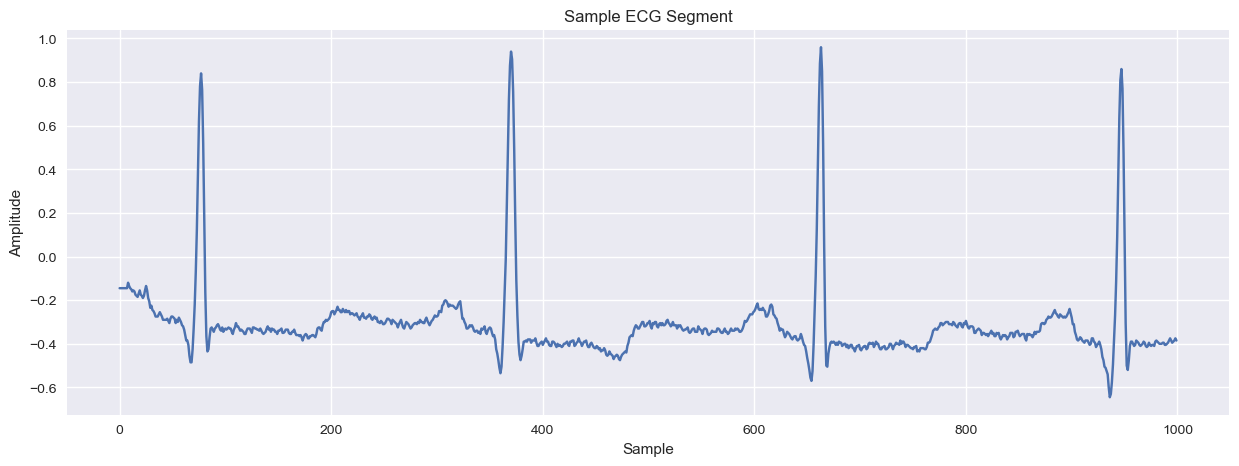

In [4]:
# Load ECG data
record_path = 'data/mit-bih-arrhythmia-database-1.0.0/100'  # Example record
record = wfdb.rdrecord(record_path)
signals = record.p_signal

# Read annotations
ann = wfdb.rdann(record_path, 'atr')
annotations = ann.symbol

# Print data information
print(f"Signal shape: {signals.shape}")
print(f"Number of annotations: {len(annotations)}")
print(f"Unique beat types: {np.unique(annotations)}")

# Plot sample ECG segment
plt.figure(figsize=(15, 5))
plt.plot(signals[:1000, 0])
plt.title('Sample ECG Segment')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

Data shape: (2273, 180, 2)
Label distribution: [2239   34]


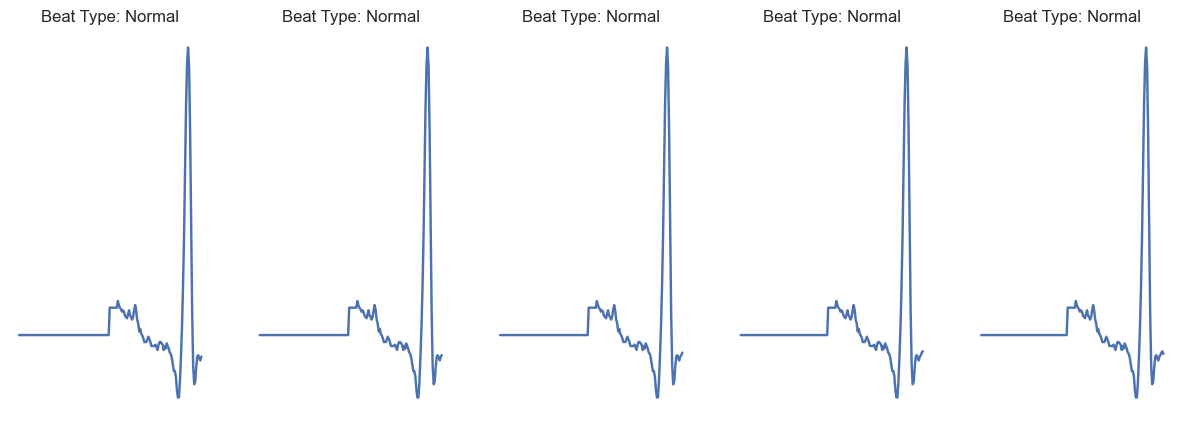

In [5]:
# Preprocess ECG data
window_size = 180

# Normalize signals
signals = (signals - np.mean(signals)) / np.std(signals)

# Extract beats
X = []
y = []

for i, ann in enumerate(annotations):
    if ann in ['N', 'L', 'R', 'A', 'V']:  # Normal and abnormal beats
        # Get window around beat
        start = max(0, i - window_size//2)
        end = min(len(signals), i + window_size//2)
        
        # Pad if necessary
        if start == 0:
            pad_left = window_size//2 - i
            segment = np.pad(signals[start:end], ((pad_left, 0), (0, 0)))
        elif end == len(signals):
            pad_right = window_size//2 - (len(signals) - i)
            segment = np.pad(signals[start:end], ((0, pad_right), (0, 0)))
        else:
            segment = signals[start:end]
        
        X.append(segment)
        
        # Convert annotation to label
        if ann == 'N':
            y.append(0)  # Normal
        else:
            y.append(1)  # Abnormal

X = np.array(X)
y = np.array(y)

print(f"Data shape: {X.shape}")
print(f"Label distribution: {np.bincount(y)}")

# Plot sample beats
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.plot(X[i, :, 0])
    plt.title(f'Beat Type: {"Normal" if y[i] == 0 else "Abnormal"}')
    plt.axis('off')
plt.show()

# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## 2. Model Implementation

In [9]:
from keras import layers

# Create simple neural network
def create_simple_nn(input_shape):
    """
    Create a simple neural network for ECG classification.
    
    Requirements:
    - Must use at least 2 dense layers
    - Must include dropout layers
    - Must use binary crossentropy loss
    - Must include AUC metric
    
    Goals:
    - Achieve > 75% accuracy on test set
    - Achieve AUC > 0.80
    - Achieve F1-score > 0.70
    - Minimize overfitting using dropout
    - Train efficiently with appropriate batch size
    
    Args:
        input_shape: Shape of input data (should be (180, 2) for ECG windows)
    
    Returns:
        Compiled Keras model
    """
    model = tf.keras.Sequential([
        layers.Input(shape=input_shape),

        # flatten layer to pass into dense layer
        layers.Flatten(),
        
        # 1st layer with batch normalization
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        # 2nd layer with batch normalization
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        
        # 3rd layer with batch normalization
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        # output layer
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',  
        metrics=[
            'accuracy',
            tf.keras.metrics.AUC(name='auc'), 
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )
    
    return model

# Create and compile model
model = create_simple_nn(input_shape=(180, 2))
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 360)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       184,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 352,769 (1.35 MB)

 Trainable params: 350,977 (1.34 MB)

 Non-trainable params: 1,792 (7.00 KB)

## 3. Training and Evaluation

Epoch 1/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5189 - auc: 0.3947 - loss: 0.9342 - precision: 0.0087 - recall: 0.2658 - val_accuracy: 0.9066 - val_auc: 0.8923 - val_loss: 0.4981 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6659 - auc: 0.6416 - loss: 0.6461 - precision: 0.0239 - recall: 0.5741 - val_accuracy: 0.9945 - val_auc: 0.3336 - val_loss: 0.2874 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8222 - auc: 0.4974 - loss: 0.4244 - precision: 0.0176 - recall: 0.1879 - val_accuracy: 0.9918 - val_auc: 0.2983 - val_loss: 0.2201 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9002 - auc: 0.4904 - loss: 0.3187 - precision: 0.0293 - recall: 0.1691 - val_accuracy: 0.9945 - val_auc: 0.5573 - val_lo

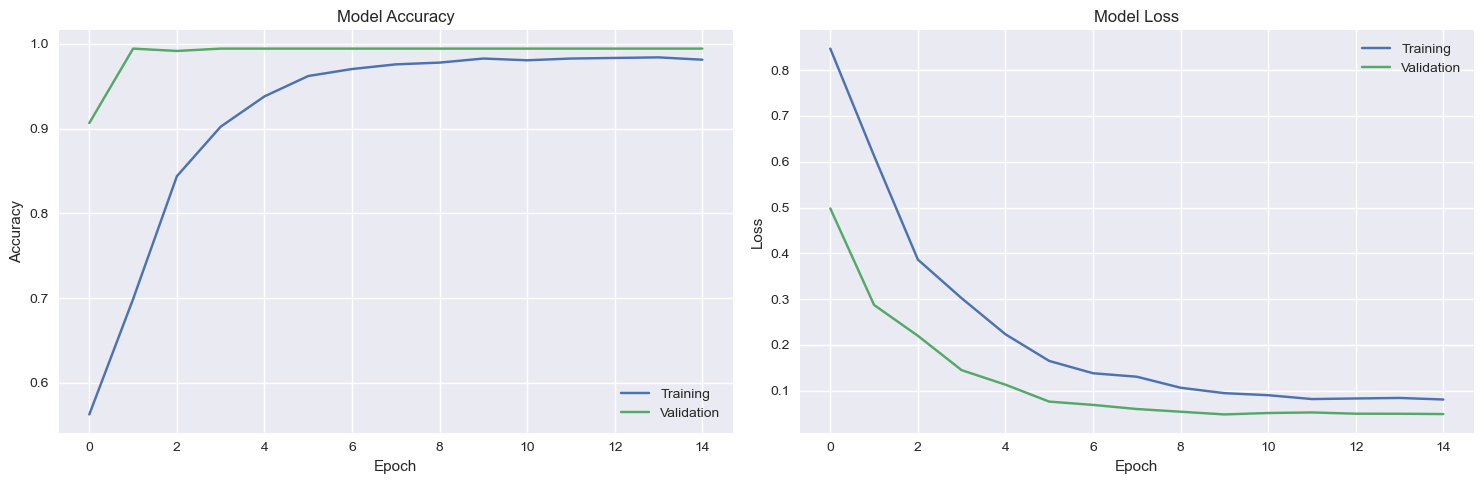

In [10]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'models/ecg_classifier.keras',
        save_best_only=True
    )
]

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=callbacks
)

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
ax1.plot(history.history['accuracy'], label='Training')
ax1.plot(history.history['val_accuracy'], label='Validation')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot loss
ax2.plot(history.history['loss'], label='Training')
ax2.plot(history.history['val_loss'], label='Validation')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9722 - auc: 0.3252 - loss: 0.1477 - precision: 0.0000e+00 - recall: 0.0000e+00 
Test accuracy: 0.9758
Test AUC: 0.5205
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


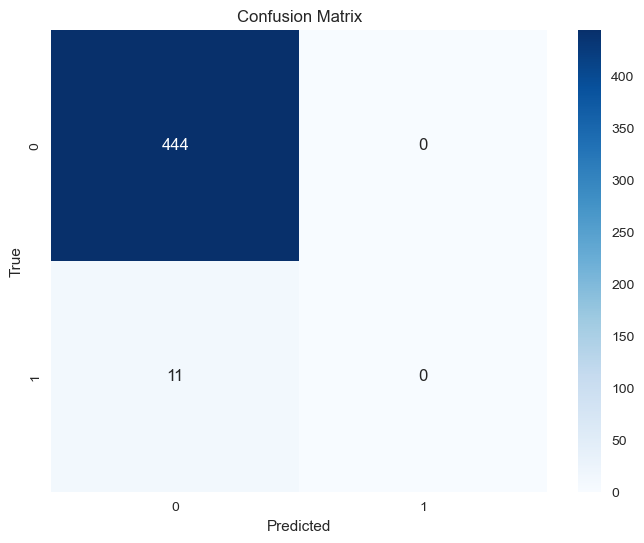

In [14]:
import seaborn as sns

# Evaluate model
test_loss, test_accuracy, test_auc, test_precision, test_recall = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Get predictions
predictions = model.predict(X_test)
predicted_labels = (predictions > 0.5).astype(int)

# Calculate confusion matrix
cm = tf.math.confusion_matrix(y_test, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Calculate additional metrics
tn, fp, fn, tp = cm.numpy().ravel()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

# Save metrics
metrics = {
    'model': 'ecg_classifier',
    'accuracy': float(test_accuracy),
    'auc': float(test_auc),
    'precision': float(precision),
    'recall': float(recall),
    'f1_score': float(f1),
    'confusion_matrix': cm.numpy().tolist()
}

# Save to file
with open('results/part_3/ecg_classifier_metrics.txt', 'w') as f:
    f.write(f"model: {metrics['model']}\n")
    f.write(f"accuracy: {metrics['accuracy']}\n")
    f.write(f"auc: {metrics['auc']}\n")
    f.write(f"precision: {metrics['precision']}\n")
    f.write(f"recall: {metrics['recall']}\n")
    f.write(f"f1_score: {metrics['f1_score']}\n")
    f.write(f"confusion_matrix: {metrics['confusion_matrix']}\n")
    f.write("----\n")